<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/GAN_Gconv_Dlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip
# !unzip /content/FullAndFracture.zip
# !rm FullAndFracture.zip

In [3]:
!gdown 1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE

Downloading...
From: https://drive.google.com/uc?id=1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE
To: /content/FullAndFracture.npy
100% 466M/466M [00:02<00:00, 210MB/s]


In [4]:
data = np.load('FullAndFracture.npy')
data.shape  #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [5]:
X = data[1] #fracturado
Y = data[0] #completo

In [6]:
plt.rcParams['figure.figsize'] = (24, 8)

def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z] >= 0.5:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  if len(points) < 1: return
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

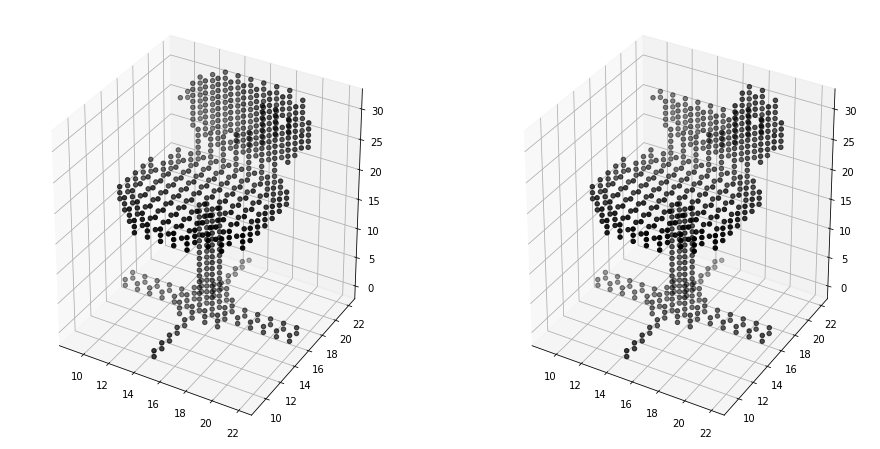

In [7]:
#@title Visualizar {run: "auto"}
id = 283 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN3D - Pytorch

In [8]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
torch.manual_seed(0)

In [9]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid, pos )

In [10]:
#@title Discriminador (Encoder)
class Discriminator(nn.Module):
  def get_block(self, input_dim, output_dim):
    return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.LeakyReLU(0.2, inplace=True)
    )

  def __init__(self, trilinear=True, im_dim=32**3, hidden_dim=128):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
      self.get_block(im_dim, hidden_dim * 4),
      self.get_block(hidden_dim * 4, hidden_dim * 2),
      self.get_block(hidden_dim * 2, hidden_dim),
      nn.Linear(hidden_dim, 1)
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    return self.disc(x)

In [11]:
#@title Generador (UNet)
class ConvBlock(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  # def __init__(self, in_channels, out_channels, mid_channels=None):
  #   super().__init__()
  #   if not mid_channels:
  #     mid_channels = out_channels
  #   self.double_conv = nn.Sequential(
  #     nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(mid_channels),
  #     nn.ReLU(inplace=True),
  #     nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(out_channels),
  #     nn.ReLU(inplace=True)
  #   )
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.double_conv(x)
    

class Generator(nn.Module):
  """Downscaling + Upscaling"""
      
  class Down(nn.Module):
    """[Block] Downscaling with AvgPool then double conv"""
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
        nn.AvgPool3d(kernel_size = 2),
        ConvBlock(in_channels, out_channels)
      )
    def forward(self, x):
      return self.maxpool_conv(x)
  
  class Up(nn.Module):
    """[Block] Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, trilinear=True):
      super().__init__()
      # if trilinear, use the normal convolutions to reduce the number of channels
      if trilinear:
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels) #, in_channels // 2
      else:
        self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)
    
  def __init__(self, trilinear=True):
    super(Generator, self).__init__()
    self.inc = ConvBlock(1, 32)      #32^3
    self.down1 = self.Down(32, 64)    #16^3
    self.down2 = self.Down(64, 128)   #8^3
    self.down3 = self.Down(128, 256)  #4^3
    self.factor = 2 if trilinear else 1
    self.down4 = self.Down(256, 512 // self.factor)
    self.up1 = self.Up(512, 256 // self.factor, trilinear)
    self.up2 = self.Up(256, 128 // self.factor, trilinear)
    self.up3 = self.Up(128, 64 // self.factor, trilinear)
    self.up4 = self.Up(64, 32, trilinear)
    self.outc = ConvBlock(32, 1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

### Funciones de Pérdida

In [12]:
def get_gen_loss(gen, disc, criterion, incomplete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [13]:
def get_disc_loss(gen, disc, criterion, incomplete, complete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(complete)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

# Guardar modelo

In [15]:
from google.colab import drive #, files
drive.mount('/gdrive')

Mounted at /gdrive


In [16]:
folder = '/gdrive/MyDrive/UPC-CC/6. Machine Learning/DiscLinear' #@param {type:'string'}

In [16]:
def save_model(n): #, download:bool = False
  torch.save(disc.state_dict(), f'{folder}/disc_{n}.pth')
  torch.save(gen.state_dict(), f'{folder}/gen_{n}.pth')
  # if download:
  #   files.download(f'{folder}/gen_{n}.pth')
  #   files.download(f'{folder}/disc_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

In [17]:
def load_model(n, model_type:str = 'gen'):
  """ model_type options: 'gen' | 'disc' """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # disc = torch.load(f'{folder}/disc_{n}.pth')
  # disc.eval()
  gen = Generator() if model_type=='gen' else Discriminator()
  gen.load_state_dict(torch.load(f'{folder}/{model_type}_{n}.pth', map_location = device))
  return gen.eval()

# Entrenar

**Dataset**

In [ ]:
size = (32,32,32)
# original shape (num_objs, 32, 32, 32)
# shape must be [num_objs, n_channels, depth,height,width]
X = X.reshape( X.shape[0], 1, *size )
Y = Y.reshape( Y.shape[0], 1, *size )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [ ]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [ ]:
n_epochs = 400
save_epoch = 10 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 96
lr = 0.00001

In [ ]:
criterion = nn.L1Loss() #.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Crear o Cargar Modelo
# Step 10000: Generator loss: 0.6930094504356386, discriminator loss: 0.6051261096000671
# Epoch 192: Generator loss: 0.04850963485240936, discriminator loss: 0.042283251881599426
# disc_24.pth and gen_24.pth were saved.
new_models = False #@param {type: 'boolean'}
if new_models:
  gen = Generator().to(device)
  disc = Discriminator().to(device)
else:
  last_n_saved = "16" #@param {type:'string'}
  gen = load_model(last_n_saved, 'gen').to(device)
  disc = load_model(last_n_saved, 'disc').to(device)

In [ ]:
# gen_opt = optim.RMSprop(gen.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
gen_opt = optim.Adam(gen.parameters(), lr=lr)
# disc_opt = optim.RMSprop(disc.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
disc_opt = optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step+1
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  for epoch in range(last_epoch+1,n_epochs):
    for incomplete, complete in tqdm(dataloader):
      cur_batch_size = len(complete)
      complete = complete.to(device=device, dtype=torch.float32)
      incomplete = incomplete.to(device=device, dtype=torch.float32)
      #Loss
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, incomplete, complete, cur_batch_size, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, incomplete, cur_batch_size, device)
      gen_loss.backward()
      gen_opt.step()
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      #Display
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        fake = gen(incomplete)
        show_tensor_images(incomplete, size, 1)
        show_tensor_images(fake, size, 2)
        show_tensor_images(complete, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    print(f"Epoch {epoch} | Step:{cur_step} \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}" )
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)

In [ ]:
train(last_step=0, last_epoch=0)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 | Step:53 	 Generator loss: 0.10376687514781956, Discriminator loss: 0.04987334561347961


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 | Step:105 	 Generator loss: 0.20308968341350558, Discriminator loss: 0.10047421270608897


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 | Step:157 	 Generator loss: 0.30294414508342743, Discriminator loss: 0.1506693229079246


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 | Step:209 	 Generator loss: 0.40196197748184187, Discriminator loss: 0.20111793375015252


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 | Step:261 	 Generator loss: 0.5027028250694274, Discriminator loss: 0.2511278046965597


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 | Step:313 	 Generator loss: 0.6019848334789274, Discriminator loss: 0.30123313009738895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 | Step:365 	 Generator loss: 0.6993873872756958, Discriminator loss: 0.3518064924478527


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 | Step:417 	 Generator loss: 0.7971747496128084, Discriminator loss: 0.4017992610335347


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 | Step:469 	 Generator loss: 0.8952078043222426, Discriminator loss: 0.4517707514762875


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: 	 Generator loss: 0.952566576004028, Discriminator loss: 0.4824261496663088
Epoch 10 | Step:521 	 Generator loss: 0.03755868756771087, Discriminator loss: 0.019175786733627322
disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 | Step:573 	 Generator loss: 0.13302902472019199, Discriminator loss: 0.06899470323324206


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 | Step:625 	 Generator loss: 0.23058470022678373, Discriminator loss: 0.11875399643182759


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 | Step:677 	 Generator loss: 0.32315582382678987, Discriminator loss: 0.16924986213445664


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 | Step:729 	 Generator loss: 0.4209386320114137, Discriminator loss: 0.2187188097834588


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 | Step:781 	 Generator loss: 0.513801143169403, Discriminator loss: 0.268448229968548


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 | Step:833 	 Generator loss: 0.6059439197778701, Discriminator loss: 0.3173031090497972


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 | Step:885 	 Generator loss: 0.704921184182167, Discriminator loss: 0.36735917627811454


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 | Step:937 	 Generator loss: 0.8075251210927965, Discriminator loss: 0.41470057415962247


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 | Step:989 	 Generator loss: 0.9098941951990129, Discriminator loss: 0.46149268513917935


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: 	 Generator loss: 0.9329931901693344, Discriminator loss: 0.4725659019351006
Epoch 20 | Step:1041 	 Generator loss: 0.06401375722885132, Discriminator loss: 0.03847609156370164
disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 | Step:1093 	 Generator loss: 0.16596233725547785, Discriminator loss: 0.0863592309951782


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 | Step:1145 	 Generator loss: 0.2655637290477753, Discriminator loss: 0.1337847425937652


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 | Step:1197 	 Generator loss: 0.34618504238128667, Discriminator loss: 0.183611806154251


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 | Step:1249 	 Generator loss: 0.4458140859603882, Discriminator loss: 0.2310120145082472


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 | Step:1301 	 Generator loss: 0.5290678496956825, Discriminator loss: 0.27966943347454065


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 | Step:1353 	 Generator loss: 0.6220736370682715, Discriminator loss: 0.33051005756855023


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 | Step:1405 	 Generator loss: 0.7246305184960363, Discriminator loss: 0.37555478906631473


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 | Step:1457 	 Generator loss: 0.8270450260043141, Discriminator loss: 0.4202921321392061


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1500: 	 Generator loss: 0.9123096306920048, Discriminator loss: 0.4588430278301241
Epoch 29 | Step:1509 	 Generator loss: 0.014851753950119019, Discriminator loss: 0.0072910338640213


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 | Step:1561 	 Generator loss: 0.10445112359523773, Discriminator loss: 0.05602501660585403
disc_3.pth and gen_3.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 | Step:1613 	 Generator loss: 0.19249357247352603, Discriminator loss: 0.10527654182910917


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 | Step:1665 	 Generator loss: 0.2845489119291306, Discriminator loss: 0.15405450636148452


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 | Step:1717 	 Generator loss: 0.3731758108139037, Discriminator loss: 0.2025839340686798


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 | Step:1769 	 Generator loss: 0.4658720833063124, Discriminator loss: 0.25025444960594184


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 | Step:1821 	 Generator loss: 0.5543500348329541, Discriminator loss: 0.2987889761328698


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 | Step:1873 	 Generator loss: 0.6360617538690561, Discriminator loss: 0.34787305551767367


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 | Step:1925 	 Generator loss: 0.7272357124090185, Discriminator loss: 0.3955524534583093


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 | Step:1977 	 Generator loss: 0.8089981043338765, Discriminator loss: 0.44493727737665195


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2000: 	 Generator loss: 0.8549309365749351, Discriminator loss: 0.4658829157948496
Epoch 39 | Step:2029 	 Generator loss: 0.04998032307624816, Discriminator loss: 0.026036080360412595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 | Step:2081 	 Generator loss: 0.12038253182172774, Discriminator loss: 0.0760243134498596
disc_4.pth and gen_4.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 | Step:2133 	 Generator loss: 0.21917594414949412, Discriminator loss: 0.12239242798089979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 | Step:2185 	 Generator loss: 0.2959852499365805, Discriminator loss: 0.17098331886529927


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 | Step:2237 	 Generator loss: 0.3835802528262138, Discriminator loss: 0.2198012285232545


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 | Step:2289 	 Generator loss: 0.4596018206477165, Discriminator loss: 0.26770179635286334


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 | Step:2341 	 Generator loss: 0.5437624620795252, Discriminator loss: 0.3159411240816115


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 | Step:2393 	 Generator loss: 0.6166379720568661, Discriminator loss: 0.3642467611432076


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 | Step:2445 	 Generator loss: 0.705067253172398, Discriminator loss: 0.4115709390044213


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 | Step:2497 	 Generator loss: 0.7749104217290878, Discriminator loss: 0.4601979416608812


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2500: 	 Generator loss: 0.7821210129261015, Discriminator loss: 0.4638220155239106
Epoch 49 | Step:2549 	 Generator loss: 0.07975032699108124, Discriminator loss: 0.04378906238079071


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 | Step:2601 	 Generator loss: 0.15116516715288167, Discriminator loss: 0.09184370481967927
disc_5.pth and gen_5.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 | Step:2653 	 Generator loss: 0.23503550118207936, Discriminator loss: 0.13796501898765554


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 | Step:2705 	 Generator loss: 0.3067287778258324, Discriminator loss: 0.18496138983964913


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 | Step:2757 	 Generator loss: 0.3859302671551704, Discriminator loss: 0.2302027657032012


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 | Step:2809 	 Generator loss: 0.46009727901220326, Discriminator loss: 0.27619988656044003


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 | Step:2861 	 Generator loss: 0.5359368328452111, Discriminator loss: 0.3221510134339332


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 | Step:2913 	 Generator loss: 0.6080070698857309, Discriminator loss: 0.36783585417270676


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 57 | Step:2965 	 Generator loss: 0.6778090090155604, Discriminator loss: 0.4124107037782672


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3000: 	 Generator loss: 0.7273340755105021, Discriminator loss: 0.4435723120570186
Epoch 58 | Step:3017 	 Generator loss: 0.026640653014183047, Discriminator loss: 0.014152758181095125


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 | Step:3069 	 Generator loss: 0.09856186556816104, Discriminator loss: 0.05691311275959014


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 | Step:3121 	 Generator loss: 0.17347260797023775, Discriminator loss: 0.10103544783592222
disc_6.pth and gen_6.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 | Step:3173 	 Generator loss: 0.23760160881280906, Discriminator loss: 0.14505359464883807


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 | Step:3225 	 Generator loss: 0.3081453571319578, Discriminator loss: 0.1876453415751458


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 | Step:3277 	 Generator loss: 0.37243892985582333, Discriminator loss: 0.22903682971000675


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 | Step:3329 	 Generator loss: 0.44032722908258437, Discriminator loss: 0.27043628418445614


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 | Step:3381 	 Generator loss: 0.507345488011837, Discriminator loss: 0.3121735773682598


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 | Step:3433 	 Generator loss: 0.5736324387192729, Discriminator loss: 0.34847644990682647


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 67 | Step:3485 	 Generator loss: 0.635924410939217, Discriminator loss: 0.3879520413875583


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3500: 	 Generator loss: 0.655594751179219, Discriminator loss: 0.39996600013971356
Epoch 68 | Step:3537 	 Generator loss: 0.044388865888118745, Discriminator loss: 0.026690509438514705


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 | Step:3589 	 Generator loss: 0.10967593830823898, Discriminator loss: 0.06350422674417494


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 | Step:3641 	 Generator loss: 0.1712792719006539, Discriminator loss: 0.10038626772165299
disc_7.pth and gen_7.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 | Step:3693 	 Generator loss: 0.2331609238386155, Discriminator loss: 0.13697168558835984


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 | Step:3745 	 Generator loss: 0.295084434270859, Discriminator loss: 0.17207547312974933


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 | Step:3797 	 Generator loss: 0.35499006354808826, Discriminator loss: 0.20725072789192198


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 | Step:3849 	 Generator loss: 0.4164704349040985, Discriminator loss: 0.24130249089002603


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 | Step:3901 	 Generator loss: 0.4758140482902529, Discriminator loss: 0.2753922486901284


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 76 | Step:3953 	 Generator loss: 0.5380712192058564, Discriminator loss: 0.3078470361828804


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4000: 	 Generator loss: 0.5957888642549516, Discriminator loss: 0.33799832355976106
Epoch 77 | Step:4005 	 Generator loss: 0.005149130463600158, Discriminator loss: 0.0023075329065322878


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 | Step:4057 	 Generator loss: 0.06726136475801468, Discriminator loss: 0.03410209232568741


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 | Step:4109 	 Generator loss: 0.13120262175798414, Discriminator loss: 0.06476084256172182


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4161 	 Generator loss: 0.19435098451375965, Discriminator loss: 0.09516565918922423
disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4213 	 Generator loss: 0.25769989258050907, Discriminator loss: 0.1258883576989174


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4265 	 Generator loss: 0.3226052084565162, Discriminator loss: 0.15611189049482338


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4317 	 Generator loss: 0.3874506917595861, Discriminator loss: 0.18600332772731779


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4369 	 Generator loss: 0.4505856645703314, Discriminator loss: 0.216323806464672


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 | Step:4421 	 Generator loss: 0.5149788692593572, Discriminator loss: 0.2467123097181319


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 | Step:4473 	 Generator loss: 0.5788225874304771, Discriminator loss: 0.27697816169261913


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.6125826019644737, Discriminator loss: 0.29352886438369746
Epoch 87 | Step:4525 	 Generator loss: 0.028996231317520146, Discriminator loss: 0.014399985909461975


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4577 	 Generator loss: 0.09209500253200531, Discriminator loss: 0.045040266692638414


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4629 	 Generator loss: 0.15357381129264838, Discriminator loss: 0.07705563330650328


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4681 	 Generator loss: 0.21530265498161325, Discriminator loss: 0.1096274645924568
disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4733 	 Generator loss: 0.277107124567032, Discriminator loss: 0.1423112569451331


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4785 	 Generator loss: 0.33989382255077366, Discriminator loss: 0.17533046680688844


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 | Step:4837 	 Generator loss: 0.4030483772754671, Discriminator loss: 0.20812451928853976


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 | Step:4889 	 Generator loss: 0.46790732777118715, Discriminator loss: 0.23980224609374984


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95 | Step:4941 	 Generator loss: 0.5331861160993578, Discriminator loss: 0.27183278053998916


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 | Step:4993 	 Generator loss: 0.5992924107313157, Discriminator loss: 0.30339005643129313


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5000: 	 Generator loss: 0.6093326910734177, Discriminator loss: 0.30832362693548165
Epoch 97 | Step:5045 	 Generator loss: 0.05520195782184602, Discriminator loss: 0.02703426092863083


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 | Step:5097 	 Generator loss: 0.12159396123886104, Discriminator loss: 0.058831829488277414


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 | Step:5149 	 Generator loss: 0.18645672035217284, Discriminator loss: 0.09012920886278149


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 | Step:5201 	 Generator loss: 0.25186950814723974, Discriminator loss: 0.12129599535465238
disc_10.pth and gen_10.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 101 | Step:5253 	 Generator loss: 0.3175361363887786, Discriminator loss: 0.15230366903543469


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 102 | Step:5305 	 Generator loss: 0.38431129837036127, Discriminator loss: 0.182874784708023


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 103 | Step:5357 	 Generator loss: 0.4516031206846239, Discriminator loss: 0.21296035301685334


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 104 | Step:5409 	 Generator loss: 0.5206626623868944, Discriminator loss: 0.2423406734764576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 105 | Step:5461 	 Generator loss: 0.5890244877338406, Discriminator loss: 0.2717524821460247


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5500: 	 Generator loss: 0.6420417425632472, Discriminator loss: 0.2939038235247135
Epoch 106 | Step:5513 	 Generator loss: 0.015879041433334348, Discriminator loss: 0.006594461679458618


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 107 | Step:5565 	 Generator loss: 0.0859291865825653, Discriminator loss: 0.03522141945362092


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 108 | Step:5617 	 Generator loss: 0.15681351780891417, Discriminator loss: 0.06408176678419115


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 109 | Step:5669 	 Generator loss: 0.2269059792757033, Discriminator loss: 0.09172661268711092


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 110 | Step:5721 	 Generator loss: 0.2978791359663008, Discriminator loss: 0.11982108378410342
disc_11.pth and gen_11.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 111 | Step:5773 	 Generator loss: 0.3684081212282178, Discriminator loss: 0.1473375217914581


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 112 | Step:5825 	 Generator loss: 0.4392049235105512, Discriminator loss: 0.17431405544280995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 113 | Step:5877 	 Generator loss: 0.5107273577451703, Discriminator loss: 0.201075745820999


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 114 | Step:5929 	 Generator loss: 0.5829276829957957, Discriminator loss: 0.22693010517954806


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 115 | Step:5981 	 Generator loss: 0.6551754386425013, Discriminator loss: 0.25317276966571794


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6000: 	 Generator loss: 0.6830008949041363, Discriminator loss: 0.26305372247099873
Epoch 116 | Step:6033 	 Generator loss: 0.04444101214408874, Discriminator loss: 0.01570277944207191


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 117 | Step:6085 	 Generator loss: 0.11805888295173643, Discriminator loss: 0.041672614216804495


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 118 | Step:6137 	 Generator loss: 0.1917496191263199, Discriminator loss: 0.0670237137973309


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 119 | Step:6189 	 Generator loss: 0.2667924690246583, Discriminator loss: 0.09276623162627232


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 120 | Step:6241 	 Generator loss: 0.34152843236923236, Discriminator loss: 0.11755337446928037
disc_12.pth and gen_12.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121 | Step:6293 	 Generator loss: 0.4172154562473298, Discriminator loss: 0.14286107587814345


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122 | Step:6345 	 Generator loss: 0.49298025500774373, Discriminator loss: 0.1674147177636625


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 123 | Step:6397 	 Generator loss: 0.5686196031570433, Discriminator loss: 0.19149375531077406


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 124 | Step:6449 	 Generator loss: 0.6441981179714202, Discriminator loss: 0.21629423409700418


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: 	 Generator loss: 0.7207005977630612, Discriminator loss: 0.24102352970838578
Epoch 125 | Step:6501 	 Generator loss: 0, Discriminator loss: 0


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126 | Step:6553 	 Generator loss: 0.0762652131319046, Discriminator loss: 0.023995470851659775


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 127 | Step:6605 	 Generator loss: 0.15291091454029082, Discriminator loss: 0.04781955420970919


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 128 | Step:6657 	 Generator loss: 0.22987998008728025, Discriminator loss: 0.07162996920943263


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 129 | Step:6709 	 Generator loss: 0.3081919041872024, Discriminator loss: 0.09627064561843875


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 130 | Step:6761 	 Generator loss: 0.3854281114339828, Discriminator loss: 0.11940498912334448
disc_13.pth and gen_13.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 131 | Step:6813 	 Generator loss: 0.4640439026355742, Discriminator loss: 0.1430825953185558


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 132 | Step:6865 	 Generator loss: 0.5422638771533965, Discriminator loss: 0.16599651366472243


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 133 | Step:6917 	 Generator loss: 0.6207819274663924, Discriminator loss: 0.18869912976026534


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 134 | Step:6969 	 Generator loss: 0.7022453281879423, Discriminator loss: 0.21076929241418835


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7000: 	 Generator loss: 0.7531466453075405, Discriminator loss: 0.2236557677090167
Epoch 135 | Step:7021 	 Generator loss: 0.030261456489562986, Discriminator loss: 0.008570661485195159


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 136 | Step:7073 	 Generator loss: 0.10970399081707, Discriminator loss: 0.03151048129796982


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 137 | Step:7125 	 Generator loss: 0.18883772683143607, Discriminator loss: 0.05456389158964157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 138 | Step:7177 	 Generator loss: 0.26819942104816435, Discriminator loss: 0.07689309406280516


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 139 | Step:7229 	 Generator loss: 0.3484555149078368, Discriminator loss: 0.0992611707448959


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 140 | Step:7281 	 Generator loss: 0.4285517369508742, Discriminator loss: 0.12140513598918909
disc_14.pth and gen_14.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 141 | Step:7333 	 Generator loss: 0.5090815221071243, Discriminator loss: 0.14268616881966595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 142 | Step:7385 	 Generator loss: 0.5897364808321003, Discriminator loss: 0.16427369254827504


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 143 | Step:7437 	 Generator loss: 0.6708131437301642, Discriminator loss: 0.18528658506274234


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 144 | Step:7489 	 Generator loss: 0.752181950330735, Discriminator loss: 0.2081441631615163


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7500: 	 Generator loss: 0.7708372361660012, Discriminator loss: 0.21304950141906748
Epoch 145 | Step:7541 	 Generator loss: 0.06326473522186278, Discriminator loss: 0.016057151705026626


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 146 | Step:7593 	 Generator loss: 0.14501916027069087, Discriminator loss: 0.036778243541717534


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 147 | Step:7645 	 Generator loss: 0.2268412371873855, Discriminator loss: 0.05769338247179985


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 148 | Step:7697 	 Generator loss: 0.30901602172851556, Discriminator loss: 0.0787994795441627


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 149 | Step:7749 	 Generator loss: 0.3911431057453153, Discriminator loss: 0.09948143371939652


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 150 | Step:7801 	 Generator loss: 0.4746078200340269, Discriminator loss: 0.11905757340788832
disc_15.pth and gen_15.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 151 | Step:7853 	 Generator loss: 0.5574362959861754, Discriminator loss: 0.14022096601128567


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 152 | Step:7905 	 Generator loss: 0.6402746660709374, Discriminator loss: 0.16034648323059067


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 153 | Step:7957 	 Generator loss: 0.7230703616142267, Discriminator loss: 0.18024889892339682


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8000: 	 Generator loss: 0.7936488294601437, Discriminator loss: 0.19666701596975306
Epoch 154 | Step:8009 	 Generator loss: 0.013311224102973938, Discriminator loss: 0.003191804051399231


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 155 | Step:8061 	 Generator loss: 0.09699476075172427, Discriminator loss: 0.023563838213682176


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 156 | Step:8113 	 Generator loss: 0.18078043520450582, Discriminator loss: 0.04303886348009109


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 157 | Step:8165 	 Generator loss: 0.26472991383075706, Discriminator loss: 0.06298183700442313


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 158 | Step:8217 	 Generator loss: 0.3483148165941239, Discriminator loss: 0.08298661607503892


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 159 | Step:8269 	 Generator loss: 0.4324605749845506, Discriminator loss: 0.10192892006039617


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 160 | Step:8321 	 Generator loss: 0.5166587132215501, Discriminator loss: 0.12144485813379283
disc_16.pth and gen_16.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 161 | Step:8373 	 Generator loss: 0.602132332324982, Discriminator loss: 0.14140481868386262


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 162 | Step:8425 	 Generator loss: 0.6863566598892219, Discriminator loss: 0.1611680224239826


  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
#dlinear 160 | Step:8321
train(last_step=8321, last_epoch=160)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 161 | Step:8374 	 Generator loss: 0.09482892274856569, Discriminator loss: 0.025771441936492914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 162 | Step:8426 	 Generator loss: 0.18006967771053314, Discriminator loss: 0.04544986444711687


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 163 | Step:8478 	 Generator loss: 0.2651288561820985, Discriminator loss: 0.06544681501388552


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8500: 	 Generator loss: 0.3027096492052079, Discriminator loss: 0.07414895799756055
Epoch 164 | Step:8530 	 Generator loss: 0.04683869886398316, Discriminator loss: 0.01118509691953659


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 165 | Step:8582 	 Generator loss: 0.13078796696662906, Discriminator loss: 0.03131690350174903


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 166 | Step:8634 	 Generator loss: 0.21510182261466976, Discriminator loss: 0.051226462841033917


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 167 | Step:8686 	 Generator loss: 0.3001886694431304, Discriminator loss: 0.07105670824646947


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 168 | Step:8738 	 Generator loss: 0.3849431096315383, Discriminator loss: 0.09072561225295063


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 169 | Step:8790 	 Generator loss: 0.4705281215906143, Discriminator loss: 0.11072822174429892


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 170 | Step:8842 	 Generator loss: 0.555453431010246, Discriminator loss: 0.13059608078002924
disc_17.pth and gen_17.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 171 | Step:8894 	 Generator loss: 0.6412150311470027, Discriminator loss: 0.15005366688966731


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 172 | Step:8946 	 Generator loss: 0.7273237057924264, Discriminator loss: 0.16949890884757027


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 173 | Step:8998 	 Generator loss: 0.8130493302345275, Discriminator loss: 0.18845878103375416


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9000: 	 Generator loss: 0.8180056344270705, Discriminator loss: 0.18944622209668144
Epoch 174 | Step:9050 	 Generator loss: 0.08129853069782257, Discriminator loss: 0.017392737150192267


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 175 | Step:9102 	 Generator loss: 0.16759146475791933, Discriminator loss: 0.03553590822219849


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 176 | Step:9154 	 Generator loss: 0.2539822310209275, Discriminator loss: 0.05463304942846299


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 177 | Step:9206 	 Generator loss: 0.3407895332574845, Discriminator loss: 0.07292056348919869


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 178 | Step:9258 	 Generator loss: 0.4282451395988464, Discriminator loss: 0.09088040062785152


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 179 | Step:9310 	 Generator loss: 0.5154080919027328, Discriminator loss: 0.10886151558160785


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 180 | Step:9362 	 Generator loss: 0.6030994217395782, Discriminator loss: 0.12662629854679117
disc_18.pth and gen_18.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 181 | Step:9414 	 Generator loss: 0.6907158880233762, Discriminator loss: 0.14453509837389003


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 182 | Step:9466 	 Generator loss: 0.7788017053604125, Discriminator loss: 0.16175628155469915


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9500: 	 Generator loss: 0.8382747801542281, Discriminator loss: 0.17340186998248128
Epoch 183 | Step:9518 	 Generator loss: 0.029068018078804013, Discriminator loss: 0.005555778831243515


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 184 | Step:9570 	 Generator loss: 0.11662736821174623, Discriminator loss: 0.023229421079158777


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 185 | Step:9622 	 Generator loss: 0.2051627810001373, Discriminator loss: 0.040708025574684115


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 186 | Step:9674 	 Generator loss: 0.2936223375797272, Discriminator loss: 0.05774621799588203


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 187 | Step:9726 	 Generator loss: 0.3824700784683228, Discriminator loss: 0.07440190351009371


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 188 | Step:9778 	 Generator loss: 0.47149460983276364, Discriminator loss: 0.09128041449189189


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 189 | Step:9830 	 Generator loss: 0.5595954490900038, Discriminator loss: 0.10881348171830181


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 190 | Step:9882 	 Generator loss: 0.648411162376404, Discriminator loss: 0.12589176151156428
disc_19.pth and gen_19.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 191 | Step:9934 	 Generator loss: 0.73753605735302, Discriminator loss: 0.1423757975250483


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 192 | Step:9986 	 Generator loss: 0.8268055405616763, Discriminator loss: 0.1589268771260978


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10000: 	 Generator loss: 0.8523256980180743, Discriminator loss: 0.16387632162868987
Epoch 193 | Step:10038 	 Generator loss: 0.06405254006385805, Discriminator loss: 0.01189311021566391


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 194 | Step:10090 	 Generator loss: 0.15357010221481326, Discriminator loss: 0.028123915761709216


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 195 | Step:10142 	 Generator loss: 0.24301986646652218, Discriminator loss: 0.044799612075090416


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 196 | Step:10194 	 Generator loss: 0.3322561038732531, Discriminator loss: 0.06169739094376566


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 197 | Step:10246 	 Generator loss: 0.42181786561012297, Discriminator loss: 0.07871082204580306


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 198 | Step:10298 	 Generator loss: 0.511529180169106, Discriminator loss: 0.09578063243627549


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 199 | Step:10350 	 Generator loss: 0.6013052331209187, Discriminator loss: 0.1123518972992897


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 200 | Step:10402 	 Generator loss: 0.6909195615053181, Discriminator loss: 0.12891462945938112
disc_20.pth and gen_20.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 201 | Step:10454 	 Generator loss: 0.7803449752330787, Discriminator loss: 0.1454186026453973


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10500: 	 Generator loss: 0.8615621005296714, Discriminator loss: 0.1608907481431963
Epoch 202 | Step:10506 	 Generator loss: 0.008679303050041198, Discriminator loss: 0.0015264792442321777


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 203 | Step:10558 	 Generator loss: 0.09865453803539277, Discriminator loss: 0.017741006314754487


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 204 | Step:10610 	 Generator loss: 0.18874062132835387, Discriminator loss: 0.03407190549373627


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 205 | Step:10662 	 Generator loss: 0.2784083117246627, Discriminator loss: 0.05075741261243817


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 206 | Step:10714 	 Generator loss: 0.3685466597080229, Discriminator loss: 0.06703795322775838


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 207 | Step:10766 	 Generator loss: 0.4590717973709105, Discriminator loss: 0.08318263986706731


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 208 | Step:10818 	 Generator loss: 0.549323721170425, Discriminator loss: 0.09984699809551235


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 209 | Step:10870 	 Generator loss: 0.6403895474672313, Discriminator loss: 0.11613384661078448


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 210 | Step:10922 	 Generator loss: 0.7307033600807185, Discriminator loss: 0.1328617881536483
disc_21.pth and gen_21.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 211 | Step:10974 	 Generator loss: 0.8209707238674155, Discriminator loss: 0.14913700845837585


  0%|          | 0/52 [00:00<?, ?it/s]

Step 11000: 	 Generator loss: 0.8679553576707831, Discriminator loss: 0.15794177192449568
Epoch 212 | Step:11026 	 Generator loss: 0.04314165759086609, Discriminator loss: 0.008262708067893981


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 213 | Step:11078 	 Generator loss: 0.13320744550228117, Discriminator loss: 0.02550196373462677


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 214 | Step:11130 	 Generator loss: 0.22371516025066382, Discriminator loss: 0.04268088054656982


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 215 | Step:11182 	 Generator loss: 0.31422255301475527, Discriminator loss: 0.059173950970172855


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 216 | Step:11234 	 Generator loss: 0.4042981247901917, Discriminator loss: 0.07502477899193757


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 217 | Step:11286 	 Generator loss: 0.4945286823511123, Discriminator loss: 0.0908321263492107


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 218 | Step:11338 	 Generator loss: 0.5852195758819576, Discriminator loss: 0.10724351251125332


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 219 | Step:11390 	 Generator loss: 0.6758296362161634, Discriminator loss: 0.12368862754106523


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 220 | Step:11442 	 Generator loss: 0.7662998002767563, Discriminator loss: 0.14041311433911327
disc_22.pth and gen_22.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 221 | Step:11494 	 Generator loss: 0.8567258093357085, Discriminator loss: 0.15629147043824204


  0%|          | 0/52 [00:00<?, ?it/s]

Step 11500: 	 Generator loss: 0.8687514259815216, Discriminator loss: 0.15847158962488186
Epoch 222 | Step:11546 	 Generator loss: 0.07875154078006742, Discriminator loss: 0.014638466477394106


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 223 | Step:11598 	 Generator loss: 0.1691510199308395, Discriminator loss: 0.032557845920324326


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 224 | Step:11650 	 Generator loss: 0.25904281258583056, Discriminator loss: 0.04869837382435799


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 225 | Step:11702 	 Generator loss: 0.3497173910140991, Discriminator loss: 0.06507412627339361


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 226 | Step:11754 	 Generator loss: 0.4397097300291062, Discriminator loss: 0.08272371584177016


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 227 | Step:11806 	 Generator loss: 0.5306609200239182, Discriminator loss: 0.09887840577960014


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 228 | Step:11858 	 Generator loss: 0.6216867985725403, Discriminator loss: 0.11457415944337845


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 229 | Step:11910 	 Generator loss: 0.7126099035739898, Discriminator loss: 0.130863105982542


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 230 | Step:11962 	 Generator loss: 0.8035475212335584, Discriminator loss: 0.14744997107982633
disc_23.pth and gen_23.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 12000: 	 Generator loss: 0.8718263286352157, Discriminator loss: 0.15883011946082112
Epoch 231 | Step:12014 	 Generator loss: 0.0225880378484726, Discriminator loss: 0.003910690695047378


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 232 | Step:12066 	 Generator loss: 0.11410878956317905, Discriminator loss: 0.019522240236401565


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 233 | Step:12118 	 Generator loss: 0.2048666456937791, Discriminator loss: 0.03557019270956518


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 234 | Step:12170 	 Generator loss: 0.29577344238758096, Discriminator loss: 0.05214109311997893


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 235 | Step:12222 	 Generator loss: 0.38671361517906216, Discriminator loss: 0.06926899330317975


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 236 | Step:12274 	 Generator loss: 0.4776113917827608, Discriminator loss: 0.08490347380936149


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 237 | Step:12326 	 Generator loss: 0.5685491691827776, Discriminator loss: 0.10091395600140098


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 238 | Step:12378 	 Generator loss: 0.6597694699764257, Discriminator loss: 0.11688015149533756


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 239 | Step:12430 	 Generator loss: 0.7506665582656862, Discriminator loss: 0.1336451631635428


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 240 | Step:12482 	 Generator loss: 0.8419724568128588, Discriminator loss: 0.14945077233016496
disc_24.pth and gen_24.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 12500: 	 Generator loss: 0.8756666576862338, Discriminator loss: 0.1555819042474032
Epoch 241 | Step:12534 	 Generator loss: 0.057116296529769885, Discriminator loss: 0.01213299384713173


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 242 | Step:12586 	 Generator loss: 0.14812627327442177, Discriminator loss: 0.028496409803628914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 243 | Step:12638 	 Generator loss: 0.23886674034595498, Discriminator loss: 0.04487591749429702


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 244 | Step:12690 	 Generator loss: 0.33064466345310217, Discriminator loss: 0.06029055538773538


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 245 | Step:12742 	 Generator loss: 0.4215591843128206, Discriminator loss: 0.07636572819948198


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 246 | Step:12794 	 Generator loss: 0.5128106065988542, Discriminator loss: 0.0923188253045082


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 247 | Step:12846 	 Generator loss: 0.6036809307336809, Discriminator loss: 0.1085200669467449


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 248 | Step:12898 	 Generator loss: 0.6950834635496139, Discriminator loss: 0.1244933339655399


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 249 | Step:12950 	 Generator loss: 0.7866110165119167, Discriminator loss: 0.14033371341228493


  0%|          | 0/52 [00:00<?, ?it/s]

Step 13000: 	 Generator loss: 0.8760468196868887, Discriminator loss: 0.15622585693001764
Epoch 250 | Step:13002 	 Generator loss: 0.001819973349571228, Discriminator loss: 0.0002814540266990662
disc_25.pth and gen_25.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 251 | Step:13054 	 Generator loss: 0.09364202511310576, Discriminator loss: 0.015832934319972992


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 252 | Step:13106 	 Generator loss: 0.184649558186531, Discriminator loss: 0.03255131575465202


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 253 | Step:13158 	 Generator loss: 0.2759359256029128, Discriminator loss: 0.049454553455114354


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 254 | Step:13210 	 Generator loss: 0.3668011165857313, Discriminator loss: 0.06694719573855398


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 255 | Step:13262 	 Generator loss: 0.45820875978469827, Discriminator loss: 0.08333448243141171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 256 | Step:13314 	 Generator loss: 0.5496725907325745, Discriminator loss: 0.09926726078987118


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 257 | Step:13366 	 Generator loss: 0.6409487062692639, Discriminator loss: 0.11566849154233924


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 258 | Step:13418 	 Generator loss: 0.7330765908956524, Discriminator loss: 0.13192223951220503


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 259 | Step:13470 	 Generator loss: 0.823455519914627, Discriminator loss: 0.14936061975359913


  0%|          | 0/52 [00:00<?, ?it/s]

Step 13500: 	 Generator loss: 0.8780921994447707, Discriminator loss: 0.15894652253389357
Epoch 260 | Step:13522 	 Generator loss: 0.03691433322429657, Discriminator loss: 0.006038408428430555
disc_26.pth and gen_26.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 261 | Step:13574 	 Generator loss: 0.12907976627349854, Discriminator loss: 0.021772865802049634


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 262 | Step:13626 	 Generator loss: 0.22091693282127392, Discriminator loss: 0.03716420435905456


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 263 | Step:13678 	 Generator loss: 0.3128483889102937, Discriminator loss: 0.052887974113225954


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 264 | Step:13730 	 Generator loss: 0.4043704607486728, Discriminator loss: 0.07014141127467158


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 265 | Step:13782 	 Generator loss: 0.49495773422718076, Discriminator loss: 0.08827352282404902


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 266 | Step:13834 	 Generator loss: 0.5862535446882252, Discriminator loss: 0.10543584898114207


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 267 | Step:13886 	 Generator loss: 0.677855278253556, Discriminator loss: 0.12158957168459893


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 268 | Step:13938 	 Generator loss: 0.76967451786995, Discriminator loss: 0.137555981874466


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 269 | Step:13990 	 Generator loss: 0.8620227923393255, Discriminator loss: 0.15304087394475946


  0%|          | 0/52 [00:00<?, ?it/s]

Step 14000: 	 Generator loss: 0.8812971282005317, Discriminator loss: 0.1565090777277947
Epoch 270 | Step:14042 	 Generator loss: 0.0727033725976944, Discriminator loss: 0.01270647317171097
disc_27.pth and gen_27.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 271 | Step:14094 	 Generator loss: 0.16434837770462032, Discriminator loss: 0.028481269493699075


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 272 | Step:14146 	 Generator loss: 0.2563038259744643, Discriminator loss: 0.044721032157540336


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 273 | Step:14198 	 Generator loss: 0.3483012216091156, Discriminator loss: 0.06229449476301671


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 274 | Step:14250 	 Generator loss: 0.4395227161645888, Discriminator loss: 0.07939596863090995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 275 | Step:14302 	 Generator loss: 0.5307240818738937, Discriminator loss: 0.09704080255329606


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 276 | Step:14354 	 Generator loss: 0.6221019383668897, Discriminator loss: 0.11292048193514342


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 277 | Step:14406 	 Generator loss: 0.7139319196939463, Discriminator loss: 0.1292724606245756


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 278 | Step:14458 	 Generator loss: 0.8059935171604151, Discriminator loss: 0.14515195690095434


  0%|          | 0/52 [00:00<?, ?it/s]

Step 14500: 	 Generator loss: 0.8819710197448721, Discriminator loss: 0.15817145927250387
Epoch 279 | Step:14510 	 Generator loss: 0.015799078464508055, Discriminator loss: 0.002731958478689194


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 280 | Step:14562 	 Generator loss: 0.10771862936019898, Discriminator loss: 0.019248909324407575
disc_28.pth and gen_28.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 281 | Step:14614 	 Generator loss: 0.19972188174724587, Discriminator loss: 0.035293252289295175


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 282 | Step:14666 	 Generator loss: 0.29211254143714915, Discriminator loss: 0.05098314587771891


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 283 | Step:14718 	 Generator loss: 0.3840516884326936, Discriminator loss: 0.06683492736518377


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 284 | Step:14770 	 Generator loss: 0.4758537151813506, Discriminator loss: 0.08303033687174317


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 285 | Step:14822 	 Generator loss: 0.5671374162435533, Discriminator loss: 0.1004557086676359


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 286 | Step:14874 	 Generator loss: 0.659599321126938, Discriminator loss: 0.11722393296658991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 287 | Step:14926 	 Generator loss: 0.7514552568197247, Discriminator loss: 0.13335076868534085


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 288 | Step:14978 	 Generator loss: 0.8436676377058027, Discriminator loss: 0.14858343413472175


  0%|          | 0/52 [00:00<?, ?it/s]

Step 15000: 	 Generator loss: 0.8840353530645367, Discriminator loss: 0.1560251875817776
Epoch 289 | Step:15030 	 Generator loss: 0.05073129308223724, Discriminator loss: 0.00997599694132805


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 290 | Step:15082 	 Generator loss: 0.14173908138275146, Discriminator loss: 0.028452005803585055
disc_29.pth and gen_29.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 291 | Step:15134 	 Generator loss: 0.2334388135671616, Discriminator loss: 0.04554293286800385


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 292 | Step:15186 	 Generator loss: 0.3256789031028749, Discriminator loss: 0.06113010510802267


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 293 | Step:15238 	 Generator loss: 0.4176849192380905, Discriminator loss: 0.07652620229125019


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 294 | Step:15290 	 Generator loss: 0.5110771189928052, Discriminator loss: 0.09245563223958013


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 295 | Step:15342 	 Generator loss: 0.6031793965101239, Discriminator loss: 0.10752607741951944


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 296 | Step:15394 	 Generator loss: 0.6950277271270748, Discriminator loss: 0.12409022492170332


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 297 | Step:15446 	 Generator loss: 0.7875752869844431, Discriminator loss: 0.1396893287748099


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 298 | Step:15498 	 Generator loss: 0.8798613227605815, Discriminator loss: 0.1554397324472667


  0%|          | 0/52 [00:00<?, ?it/s]

Step 15500: 	 Generator loss: 0.8852122905254358, Discriminator loss: 0.15638681684434425
Epoch 299 | Step:15550 	 Generator loss: 0.08730025100708008, Discriminator loss: 0.013922231987118719


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 300 | Step:15602 	 Generator loss: 0.17939360558986672, Discriminator loss: 0.030029102355241772
disc_30.pth and gen_30.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 301 | Step:15654 	 Generator loss: 0.27167548310756695, Discriminator loss: 0.045890664219856214


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 302 | Step:15706 	 Generator loss: 0.36362095236778263, Discriminator loss: 0.06133987222611899


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 303 | Step:15758 	 Generator loss: 0.4563182557821275, Discriminator loss: 0.07672690524160858


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 304 | Step:15810 	 Generator loss: 0.5483344845771789, Discriminator loss: 0.09451471848785879


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 305 | Step:15862 	 Generator loss: 0.640197154045105, Discriminator loss: 0.1106850288361311


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 306 | Step:15914 	 Generator loss: 0.7327345296144485, Discriminator loss: 0.12681346730887896


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 307 | Step:15966 	 Generator loss: 0.8245486346483228, Discriminator loss: 0.14288480769097817


  0%|          | 0/52 [00:00<?, ?it/s]

Step 16000: 	 Generator loss: 0.8869546926021575, Discriminator loss: 0.1532290121763946
Epoch 308 | Step:16018 	 Generator loss: 0.030157786011695865, Discriminator loss: 0.005023003086447716


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 309 | Step:16070 	 Generator loss: 0.1225275011062622, Discriminator loss: 0.020416812494397155


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 310 | Step:16122 	 Generator loss: 0.21492758846282964, Discriminator loss: 0.03605647118389606
disc_31.pth and gen_31.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 311 | Step:16174 	 Generator loss: 0.30759569025039685, Discriminator loss: 0.0517457332164049


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 312 | Step:16226 	 Generator loss: 0.40049166905879996, Discriminator loss: 0.06735978753864763


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 313 | Step:16278 	 Generator loss: 0.49330498445034054, Discriminator loss: 0.08360577966272824


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 314 | Step:16330 	 Generator loss: 0.5860261996984482, Discriminator loss: 0.10004858653247352


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 315 | Step:16382 	 Generator loss: 0.6781197347640989, Discriminator loss: 0.11589213319122788


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 316 | Step:16434 	 Generator loss: 0.7705553294420241, Discriminator loss: 0.13104426871240127


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 317 | Step:16486 	 Generator loss: 0.8631377438306811, Discriminator loss: 0.14678113992512207


  0%|          | 0/52 [00:00<?, ?it/s]

Step 16500: 	 Generator loss: 0.8895557774305347, Discriminator loss: 0.151621407791972
Epoch 318 | Step:16538 	 Generator loss: 0.06510111486911775, Discriminator loss: 0.011703545033931732


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 319 | Step:16590 	 Generator loss: 0.15671058738231655, Discriminator loss: 0.027858072191476818


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 320 | Step:16642 	 Generator loss: 0.2489572637081145, Discriminator loss: 0.04397687774896623
disc_32.pth and gen_32.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 321 | Step:16694 	 Generator loss: 0.3418305181264878, Discriminator loss: 0.05933710035681728


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 322 | Step:16746 	 Generator loss: 0.43372171628475187, Discriminator loss: 0.07571671432256696


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 323 | Step:16798 	 Generator loss: 0.5261593488454819, Discriminator loss: 0.09178018635511397


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 324 | Step:16850 	 Generator loss: 0.6186225054264073, Discriminator loss: 0.10759304410219189


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 325 | Step:16902 	 Generator loss: 0.711420451998711, Discriminator loss: 0.1235110800266266


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 326 | Step:16954 	 Generator loss: 0.8031571363210681, Discriminator loss: 0.13999018219113354


  0%|          | 0/52 [00:00<?, ?it/s]

Step 17000: 	 Generator loss: 0.8859604369401934, Discriminator loss: 0.1550656352937222
Epoch 327 | Step:17006 	 Generator loss: 0.00878432857990265, Discriminator loss: 0.0015157778561115266


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 328 | Step:17058 	 Generator loss: 0.10167211389541625, Discriminator loss: 0.017784401029348376


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 329 | Step:17110 	 Generator loss: 0.19355180931091306, Discriminator loss: 0.03420256623625756


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 330 | Step:17162 	 Generator loss: 0.28636328697204577, Discriminator loss: 0.05002167719602586
disc_33.pth and gen_33.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 331 | Step:17214 	 Generator loss: 0.37870779359340667, Discriminator loss: 0.06652807214856149


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 332 | Step:17266 	 Generator loss: 0.47097900569438944, Discriminator loss: 0.08333505314588556


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 333 | Step:17318 	 Generator loss: 0.5642782300710681, Discriminator loss: 0.09927544426918039


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 334 | Step:17370 	 Generator loss: 0.6569292306900024, Discriminator loss: 0.11514790558815008


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 335 | Step:17422 	 Generator loss: 0.7493685128688808, Discriminator loss: 0.13074304863810543


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 336 | Step:17474 	 Generator loss: 0.8415705927610395, Discriminator loss: 0.14703635212779045


  0%|          | 0/52 [00:00<?, ?it/s]

Step 17500: 	 Generator loss: 0.8892531120777127, Discriminator loss: 0.1564615026414395
Epoch 337 | Step:17526 	 Generator loss: 0.04427957856655121, Discriminator loss: 0.00907856085896492


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 338 | Step:17578 	 Generator loss: 0.13664193189144133, Discriminator loss: 0.026262752354145047


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 339 | Step:17630 	 Generator loss: 0.22996290218830107, Discriminator loss: 0.04160361321270466


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 340 | Step:17682 	 Generator loss: 0.3220432665348053, Discriminator loss: 0.05786764360964298
disc_34.pth and gen_34.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 341 | Step:17734 	 Generator loss: 0.41386544907093054, Discriminator loss: 0.07395769055187702


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 342 | Step:17786 	 Generator loss: 0.5066640405654906, Discriminator loss: 0.0904137960523367


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 343 | Step:17838 	 Generator loss: 0.5997548497915264, Discriminator loss: 0.10532113921642308


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 344 | Step:17890 	 Generator loss: 0.6926564460992809, Discriminator loss: 0.12086032575368887


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 345 | Step:17942 	 Generator loss: 0.7851453363895415, Discriminator loss: 0.1374808116555215


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 346 | Step:17994 	 Generator loss: 0.8775585950613024, Discriminator loss: 0.15304610712826253


  0%|          | 0/52 [00:00<?, ?it/s]

Step 18000: 	 Generator loss: 0.8899701287746431, Discriminator loss: 0.15514723132550717
Epoch 347 | Step:18046 	 Generator loss: 0.08001702392101287, Discriminator loss: 0.014241171330213548


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 348 | Step:18098 	 Generator loss: 0.17246879231929785, Discriminator loss: 0.03044981947541238


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 349 | Step:18150 	 Generator loss: 0.2651807993650436, Discriminator loss: 0.04689973172545436


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 350 | Step:18202 	 Generator loss: 0.35808114910125727, Discriminator loss: 0.06257916183769706
disc_35.pth and gen_35.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 351 | Step:18254 	 Generator loss: 0.45035757029056545, Discriminator loss: 0.078470811828971


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 352 | Step:18306 	 Generator loss: 0.543007190823555, Discriminator loss: 0.0936500857323409


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 353 | Step:18358 	 Generator loss: 0.6356001975536346, Discriminator loss: 0.11035537414252768


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 354 | Step:18410 	 Generator loss: 0.7286197479963304, Discriminator loss: 0.1264077861756087


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 355 | Step:18462 	 Generator loss: 0.8211803388595583, Discriminator loss: 0.1415865948349238


  0%|          | 0/52 [00:00<?, ?it/s]

Step 18500: 	 Generator loss: 0.8900363670587542, Discriminator loss: 0.15401942719519146
Epoch 356 | Step:18514 	 Generator loss: 0.02324001455307007, Discriminator loss: 0.004067862659692764


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 357 | Step:18566 	 Generator loss: 0.11601951062679292, Discriminator loss: 0.019364913552999494


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 358 | Step:18618 	 Generator loss: 0.20904242098331458, Discriminator loss: 0.03547745704650879


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 359 | Step:18670 	 Generator loss: 0.30235260295867944, Discriminator loss: 0.05159490805864333


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 360 | Step:18722 	 Generator loss: 0.3954956930875778, Discriminator loss: 0.06710377979278562
disc_36.pth and gen_36.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 361 | Step:18774 	 Generator loss: 0.487468133330345, Discriminator loss: 0.08377675849199293


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 362 | Step:18826 	 Generator loss: 0.5802640768289565, Discriminator loss: 0.09942414966225617


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 363 | Step:18878 	 Generator loss: 0.6730837190151217, Discriminator loss: 0.11497004285454747


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 364 | Step:18930 	 Generator loss: 0.7656742827892302, Discriminator loss: 0.13066124281287186


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 365 | Step:18982 	 Generator loss: 0.8579019923210145, Discriminator loss: 0.1472839700579642


  0%|          | 0/52 [00:00<?, ?it/s]

Step 19000: 	 Generator loss: 0.8917170890569687, Discriminator loss: 0.15317641779780378
Epoch 366 | Step:19034 	 Generator loss: 0.059429189562797545, Discriminator loss: 0.010069574862718582


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 367 | Step:19086 	 Generator loss: 0.15226286804676062, Discriminator loss: 0.026022309422492996


  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
save_model('last')

NameError: ignored

In [ ]:
train(last_step=0, last_epoch=0)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0 | Step:52 	 Generator loss: 0.06678547227382658, Discriminator loss: 0.054370588779449454


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 | Step:104 	 Generator loss: 0.13047760951519013, Discriminator loss: 0.10634928292036053


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 | Step:156 	 Generator loss: 0.19414515209198005, Discriminator loss: 0.15823325848579398


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 | Step:208 	 Generator loss: 0.2578914036750794, Discriminator loss: 0.2100862884521484


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 | Step:260 	 Generator loss: 0.3219698414802551, Discriminator loss: 0.2618467497229575


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 | Step:312 	 Generator loss: 0.3864989117383957, Discriminator loss: 0.3134280427694318


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 | Step:364 	 Generator loss: 0.4518021422624588, Discriminator loss: 0.36477793735265723


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 | Step:416 	 Generator loss: 0.5176792366504668, Discriminator loss: 0.4157028712630272


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 | Step:468 	 Generator loss: 0.5843934687376022, Discriminator loss: 0.4661098656058313


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: 	 Generator loss: 0.6267836515903471, Discriminator loss: 0.49798774224519743
Epoch 9 | Step:520 	 Generator loss: 0.024411672234535223, Discriminator loss: 0.018272165417671207


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 | Step:572 	 Generator loss: 0.09163913536071777, Discriminator loss: 0.06799660652875901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 | Step:624 	 Generator loss: 0.15932080805301668, Discriminator loss: 0.11727040827274327


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 | Step:676 	 Generator loss: 0.22733894288539885, Discriminator loss: 0.166100840330124


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 | Step:728 	 Generator loss: 0.29584632039070113, Discriminator loss: 0.21454988068342218


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 | Step:780 	 Generator loss: 0.3651761422157286, Discriminator loss: 0.2626094845533371


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 | Step:832 	 Generator loss: 0.4351611897945401, Discriminator loss: 0.3104395597577097


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 | Step:884 	 Generator loss: 0.5056212730407712, Discriminator loss: 0.35813460856676116


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 | Step:936 	 Generator loss: 0.5758786782026291, Discriminator loss: 0.4058901804685595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 | Step:988 	 Generator loss: 0.645947934985161, Discriminator loss: 0.4536664874553683


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: 	 Generator loss: 0.6633573387861252, Discriminator loss: 0.465744108617306
Epoch 19 | Step:1040 	 Generator loss: 0.05234611606597899, Discriminator loss: 0.036027827858924874


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 | Step:1092 	 Generator loss: 0.12235418629646301, Discriminator loss: 0.0839489567279816


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 | Step:1144 	 Generator loss: 0.1924852540493011, Discriminator loss: 0.1318830176591873


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 | Step:1196 	 Generator loss: 0.26264107668399794, Discriminator loss: 0.17978645509481433


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 | Step:1248 	 Generator loss: 0.33278355109691576, Discriminator loss: 0.2277840726971626


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 | Step:1300 	 Generator loss: 0.40301291024684854, Discriminator loss: 0.2757353131175041


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 | Step:1352 	 Generator loss: 0.47348534214496574, Discriminator loss: 0.323590078175068


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 | Step:1404 	 Generator loss: 0.5442969493865961, Discriminator loss: 0.3712820419669153


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 | Step:1456 	 Generator loss: 0.615283704400062, Discriminator loss: 0.4188479486107829


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1500: 	 Generator loss: 0.6765157370567316, Discriminator loss: 0.46021905261278184
Epoch 28 | Step:1508 	 Generator loss: 0.009518527507781982, Discriminator loss: 0.006423209965229035


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 | Step:1560 	 Generator loss: 0.08009848821163175, Discriminator loss: 0.0544555597305298


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 | Step:1612 	 Generator loss: 0.15101545882225034, Discriminator loss: 0.10216629970073698


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_3.pth and gen_3.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 | Step:1664 	 Generator loss: 0.2223047207593917, Discriminator loss: 0.14983376079797747


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 | Step:1716 	 Generator loss: 0.2934429126977919, Discriminator loss: 0.19749847996234887


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 | Step:1768 	 Generator loss: 0.36461215066909763, Discriminator loss: 0.2452148106098174


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 | Step:1820 	 Generator loss: 0.4361001552343365, Discriminator loss: 0.29277203464508034


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 | Step:1872 	 Generator loss: 0.5076659927368162, Discriminator loss: 0.3402515015006063


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 | Step:1924 	 Generator loss: 0.579345577359199, Discriminator loss: 0.38765480655431717


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 | Step:1976 	 Generator loss: 0.6510953122377392, Discriminator loss: 0.4350390700697894


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2000: 	 Generator loss: 0.6854934413433073, Discriminator loss: 0.4579079935550685
Epoch 38 | Step:2028 	 Generator loss: 0.037433149576187125, Discriminator loss: 0.024473158955574028


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 | Step:2080 	 Generator loss: 0.10888612580299378, Discriminator loss: 0.07217285305261613


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 | Step:2132 	 Generator loss: 0.18067705607414247, Discriminator loss: 0.11950546944141391


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_4.pth and gen_4.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 | Step:2184 	 Generator loss: 0.252733726143837, Discriminator loss: 0.16674366712570193


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 | Step:2236 	 Generator loss: 0.32477070546150183, Discriminator loss: 0.21401195180416113


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 | Step:2288 	 Generator loss: 0.3968636425733567, Discriminator loss: 0.2611965354681017


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 | Step:2340 	 Generator loss: 0.4690855020284652, Discriminator loss: 0.3083688690662386


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 | Step:2392 	 Generator loss: 0.5415860484838484, Discriminator loss: 0.3552948278784752


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 | Step:2444 	 Generator loss: 0.6133477536439893, Discriminator loss: 0.4028317586779595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 | Step:2496 	 Generator loss: 0.6859672569036481, Discriminator loss: 0.44967861396074305


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2500: 	 Generator loss: 0.6929737613201139, Discriminator loss: 0.4541702153086663
Epoch 48 | Step:2548 	 Generator loss: 0.06532307767868045, Discriminator loss: 0.04265120100975037


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 | Step:2600 	 Generator loss: 0.1377565521001816, Discriminator loss: 0.08968218266963958


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 | Step:2652 	 Generator loss: 0.21021886551380164, Discriminator loss: 0.13679387557506562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_5.pth and gen_5.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 | Step:2704 	 Generator loss: 0.2829190974235535, Discriminator loss: 0.18386264890432366


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 | Step:2756 	 Generator loss: 0.3558379839658737, Discriminator loss: 0.23064058417081837


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 | Step:2808 	 Generator loss: 0.42854677140712727, Discriminator loss: 0.27754028493165983


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 | Step:2860 	 Generator loss: 0.5015671919584275, Discriminator loss: 0.324261920809746


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 | Step:2912 	 Generator loss: 0.5745891402959824, Discriminator loss: 0.37093277335166946


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 | Step:2964 	 Generator loss: 0.6476272413730619, Discriminator loss: 0.41785566884279274


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3000: 	 Generator loss: 0.6993971624374387, Discriminator loss: 0.45128931474685685
Epoch 57 | Step:3016 	 Generator loss: 0.020894852995872494, Discriminator loss: 0.013598295927047728


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 | Step:3068 	 Generator loss: 0.09309896612167357, Discriminator loss: 0.06106711399555207


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 | Step:3120 	 Generator loss: 0.16583614122867585, Discriminator loss: 0.10804293674230575


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 | Step:3172 	 Generator loss: 0.2387304909229279, Discriminator loss: 0.1549906562566757


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_6.pth and gen_6.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 | Step:3224 	 Generator loss: 0.3115358337163925, Discriminator loss: 0.20199579900503156


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 | Step:3276 	 Generator loss: 0.3852023513317107, Discriminator loss: 0.24848010385036462


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 | Step:3328 	 Generator loss: 0.4584219324588773, Discriminator loss: 0.29507913553714754


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 | Step:3380 	 Generator loss: 0.5315221773385999, Discriminator loss: 0.34193571013212204


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 | Step:3432 	 Generator loss: 0.6047783460617067, Discriminator loss: 0.3886975687742235


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 | Step:3484 	 Generator loss: 0.6782851852178575, Discriminator loss: 0.4352179742455484


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3500: 	 Generator loss: 0.7021186952590944, Discriminator loss: 0.45050145047903073
Epoch 67 | Step:3536 	 Generator loss: 0.049182327389717104, Discriminator loss: 0.031612193644046785


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 | Step:3588 	 Generator loss: 0.12248200333118445, Discriminator loss: 0.07834816008806227


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 | Step:3640 	 Generator loss: 0.19613976407051092, Discriminator loss: 0.12462312757968896


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 | Step:3692 	 Generator loss: 0.2693589169979097, Discriminator loss: 0.17144260883331294


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_7.pth and gen_7.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 | Step:3744 	 Generator loss: 0.34307728111743935, Discriminator loss: 0.2178807500600814


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 | Step:3796 	 Generator loss: 0.41682462263107295, Discriminator loss: 0.2641937053203583


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 | Step:3848 	 Generator loss: 0.48974777328968044, Discriminator loss: 0.31108723330497745


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 | Step:3900 	 Generator loss: 0.5628054523468019, Discriminator loss: 0.35807381772994984


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 | Step:3952 	 Generator loss: 0.6366872948408127, Discriminator loss: 0.40432123804092385


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4000: 	 Generator loss: 0.7063195248842242, Discriminator loss: 0.4479334508180615
Epoch 76 | Step:4004 	 Generator loss: 0.0043231468200683595, Discriminator loss: 0.0026214997172355654


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 | Step:4056 	 Generator loss: 0.07837222492694856, Discriminator loss: 0.0487118552327156


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 | Step:4108 	 Generator loss: 0.15197181630134587, Discriminator loss: 0.09535361635684965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 | Step:4160 	 Generator loss: 0.2262242220640182, Discriminator loss: 0.1413991110324859


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4212 	 Generator loss: 0.30036994922161103, Discriminator loss: 0.18750596249103535


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4264 	 Generator loss: 0.3737696261405946, Discriminator loss: 0.2341766977906226


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4316 	 Generator loss: 0.44810914695262893, Discriminator loss: 0.28021482580900176


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4368 	 Generator loss: 0.5223353545665742, Discriminator loss: 0.3263841091990469


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4420 	 Generator loss: 0.5961464560031895, Discriminator loss: 0.37286714047193503


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 | Step:4472 	 Generator loss: 0.6704649758338933, Discriminator loss: 0.41890594989061314


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.7119087358713152, Discriminator loss: 0.44457593405246687
Epoch 86 | Step:4524 	 Generator loss: 0.032909751653671264, Discriminator loss: 0.0203499156832695


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 | Step:4576 	 Generator loss: 0.10695199918746949, Discriminator loss: 0.06650678002834319


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4628 	 Generator loss: 0.18133579111099246, Discriminator loss: 0.11260627740621565


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4680 	 Generator loss: 0.25511993336677546, Discriminator loss: 0.15893632024526588


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4732 	 Generator loss: 0.3296570883989335, Discriminator loss: 0.20498961067199706


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4784 	 Generator loss: 0.40427709686756147, Discriminator loss: 0.2508923869132995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4836 	 Generator loss: 0.47879236912727385, Discriminator loss: 0.29679379653930643


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4264 	 Generator loss: 0.10042173123359675, Discriminator loss: 0.05932919263839721
disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4316 	 Generator loss: 0.2043191175460815, Discriminator loss: 0.11088251554965968


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4368 	 Generator loss: 0.30831909883022307, Discriminator loss: 0.16176754868030535


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4420 	 Generator loss: 0.4123190882205963, Discriminator loss: 0.21229671865701671


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4472 	 Generator loss: 0.5163190580606463, Discriminator loss: 0.2626244229674339


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.5743190356492999, Discriminator loss: 0.29064632946252816
Epoch 85 | Step:4524 	 Generator loss: 0.04599992060661317, Discriminator loss: 0.022184318363666532


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 | Step:4576 	 Generator loss: 0.14999982297420508, Discriminator loss: 0.07220899122953417


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 | Step:4628 	 Generator loss: 0.2539995667934418, Discriminator loss: 0.12200067162513736


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4680 	 Generator loss: 0.35799948108196256, Discriminator loss: 0.17150868058204657


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4732 	 Generator loss: 0.4619992346763611, Discriminator loss: 0.22066228586435319


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4784 	 Generator loss: 0.5659987246990205, Discriminator loss: 0.2694329161643982
disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4836 	 Generator loss: 0.6699983659982683, Discriminator loss: 0.31789504456520085


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4888 	 Generator loss: 0.7739969718456273, Discriminator loss: 0.36589481371641175


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 | Step:4940 	 Generator loss: 0.8770169727802283, Discriminator loss: 0.41607060855627076


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 | Step:4992 	 Generator loss: 0.9803734946250917, Discriminator loss: 0.46797594553232197


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5000: 	 Generator loss: 0.9983163985013963, Discriminator loss: 0.4769469608664512
Epoch 95 | Step:5044 	 Generator loss: 0.08566452634334562, Discriminator loss: 0.04287583196163178


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 | Step:5096 	 Generator loss: 0.18918638193607323, Discriminator loss: 0.09470002675056456


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 | Step:5148 	 Generator loss: 0.292686314344406, Discriminator loss: 0.14649938064813622


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 | Step:5200 	 Generator loss: 0.39617829477787003, Discriminator loss: 0.19827917718887336


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 | Step:5252 	 Generator loss: 0.49967680048942553, Discriminator loss: 0.25005042552948


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 | Step:5304 	 Generator loss: 0.603123296737671, Discriminator loss: 0.3018125337958337
disc_10.pth and gen_10.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 101 | Step:5356 	 Generator loss: 0.7065097267627715, Discriminator loss: 0.3535608323812486


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 102 | Step:5408 	 Generator loss: 0.8098192062377932, Discriminator loss: 0.4052817758321763


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 103 | Step:5460 	 Generator loss: 0.9131207685470584, Discriminator loss: 0.45697815549373616


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5500: 	 Generator loss: 0.9945618393421176, Discriminator loss: 0.49772166347503655
Epoch 104 | Step:5512 	 Generator loss: 0.02184606325626373, Discriminator loss: 0.010928918600082396


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 105 | Step:5564 	 Generator loss: 0.12507656526565553, Discriminator loss: 0.06256822705268861


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 106 | Step:5616 	 Generator loss: 0.22819982302188882, Discriminator loss: 0.11415538811683655


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 107 | Step:5668 	 Generator loss: 0.33124710869789126, Discriminator loss: 0.16568562257289876


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 108 | Step:5720 	 Generator loss: 0.4342010837793349, Discriminator loss: 0.21715589380264272


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 109 | Step:5772 	 Generator loss: 0.5370920389890671, Discriminator loss: 0.26861704474687564


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 110 | Step:5824 	 Generator loss: 0.6398645482063294, Discriminator loss: 0.32008791506290435
disc_11.pth and gen_11.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 111 | Step:5876 	 Generator loss: 0.7425306115150452, Discriminator loss: 0.3715327600240709


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 112 | Step:5928 	 Generator loss: 0.8450374076366425, Discriminator loss: 0.42291466188430793


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 113 | Step:5980 	 Generator loss: 0.9474522664546965, Discriminator loss: 0.4742397714853287


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6000: 	 Generator loss: 0.988780559539795, Discriminator loss: 0.49495069521665574
Epoch 114 | Step:6032 	 Generator loss: 0.06098606812953949, Discriminator loss: 0.03055411064624786


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 115 | Step:6084 	 Generator loss: 0.16325575375556947, Discriminator loss: 0.08178982478380205


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 116 | Step:6136 	 Generator loss: 0.26541636645793903, Discriminator loss: 0.13297388237714772


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 117 | Step:6188 	 Generator loss: 0.36742223513126365, Discriminator loss: 0.18406686693429955


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 118 | Step:6240 	 Generator loss: 0.4693870635032652, Discriminator loss: 0.2351199935078622


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 119 | Step:6292 	 Generator loss: 0.5713614405393599, Discriminator loss: 0.2861552344560623


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 120 | Step:6344 	 Generator loss: 0.6731825437545773, Discriminator loss: 0.33710409981012346
disc_12.pth and gen_12.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121 | Step:6396 	 Generator loss: 0.7749464340209958, Discriminator loss: 0.38798834913969044


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122 | Step:6448 	 Generator loss: 0.8767117216587063, Discriminator loss: 0.4388541963100434


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 123 | Step:6500 	 Generator loss: 0.9784430606365196, Discriminator loss: 0.4896904489398004


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: 	 Generator loss: 0.9803993054628365, Discriminator loss: 0.4906659531593324
Epoch 124 | Step:6552 	 Generator loss: 0.09969290602207184, Discriminator loss: 0.04981914830207826


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 125 | Step:6604 	 Generator loss: 0.2013192139863968, Discriminator loss: 0.10056311428546906


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126 | Step:6656 	 Generator loss: 0.3029347904920579, Discriminator loss: 0.15131182110309593


  0%|          | 0/52 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

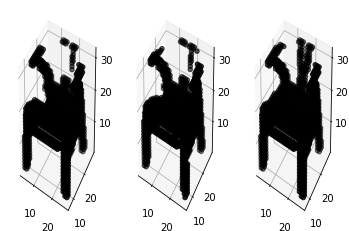

In [ ]:
train(last_step=4212, last_epoch=80)

In [ ]:
# limpiar memoria
# with torch.no_grad():
#   torch.cuda.empty_cache()

# Testing

## Cargar Objeto de Prueba

In [18]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true -O broken_chair.npy

--2022-11-23 18:41:16--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy [following]
--2022-11-23 18:41:16--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy [following]
--2022-11-23 18:41:17--  https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185

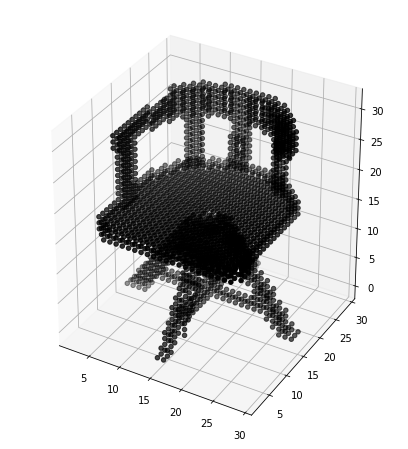

In [19]:
filename = 'broken_chair.npy' #@param {type:'string'}
array = np.load(filename)
showArr3DBoolC(array)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
array_t = torch.from_numpy( array.reshape(1,1, 32,32,32) ).float().to(device)
array_t.shape

torch.Size([1, 1, 32, 32, 32])

## Visualizar 3D

In [24]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math

In [25]:
def plot3d(verts, s=10, c=(105,127,155), show_grid=False):
    x, y, z = zip(*verts)
    color = f'rgb({c[0]}, {c[1]}, {c[2]})'
    trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=s,
            color=color,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=1
        )
    )
    data = [trace]
    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene = go.Scene(
            xaxis=dict(visible=show_grid),
            yaxis=dict(visible=show_grid),
            zaxis=dict(visible=show_grid)
        )
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [26]:
def point_cloud_to_volume(points, vsize, radius=1.0):
    vol = np.zeros((vsize,vsize,vsize), dtype=np.bool)
    voxel = 2*radius/float(vsize)
    locations = (points + radius)/voxel
    locations = locations.astype(int)
    vol[locations[:,0],locations[:,1],locations[:,2]] = 1.0
    
    return vol

In [27]:
def volume_to_point_cloud(vol):
    """ vol is occupancy grid (value = 0 or 1) of size vsize*vsize*vsize
        return Nx3 numpy array.
    """
    vsize = vol.shape[0]
    assert(vol.shape[1] == vsize and vol.shape[1] == vsize)
    points = []
    for a in range(vsize):
        for b in range(vsize):
            for c in range(vsize):
                if vol[a,b,c] == 1:
                    points.append(np.array([a,b,c]))
    if len(points) == 0:
        return np.zeros((0,3))
    points = np.vstack(points)
    
    return points

def auto_pcl_to_volume(points, vsize):
	data_min = np.min(points)
	data_max = np.max(points)
	radius = max(abs(data_min), data_max)
	radius = math.ceil(radius*100) / 100
	vol = point_cloud_to_volume(points, vsize, radius)

	return vol

In [28]:
def plot_vol(vol, s=10, c=(105,127,155), show_grid=False):
    if vol.dtype != np.bool:
        vol = vol > 0

    pc = volume_to_point_cloud(vol)
    plot3d(pc, s, c, show_grid)

In [32]:
def plot_reconstruction(vol1, vol2, s=10,
                        c2=(105,128,155), c1=(182,49,62), show_grid=False):
    if vol1.dtype != np.bool:
        vol1 = vol1 > 0
    if vol2.dtype != np.bool:
        vol2 = vol2 > 0
        
    color1 = f'rgb({c1[0]}, {c1[1]}, {c1[2]})'
    color2 = f'rgb({c2[0]}, {c2[1]}, {c2[2]})'
    vol2 = np.logical_xor(vol2, vol1)
    pc1 = volume_to_point_cloud(vol1)
    pc2 = volume_to_point_cloud(vol2)
    x1, y1, z1 = zip(*pc1)
    x2, y2, z2 = zip(*pc2)
    trace1 = go.Scatter3d(
        x=x1, y=y1, z=z1,
        mode='markers',
        marker=dict(
            size=s,
            color=color1,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=1
        )
    )
    trace2 = go.Scatter3d(
        x=x2, y=y2, z=z2,
        mode='markers',
        marker=dict(
            size=s,
            color=color2,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=1
        )
    )
    data = [trace1, trace2]
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), 
                       scene = go.Scene(
                               xaxis=dict(visible=show_grid),
                               yaxis=dict(visible=show_grid),
                               zaxis=dict(visible=show_grid)),
                       showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

## Cargar modelo

In [49]:
last_n_saved = 34 #@param {type:'slider', min:1, max:34, step:1}
#folder = '/content' #@param {type:'string'}
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen2 = load_model(last_n_saved, 'gen').to(device)
generated = gen2(array_t).round()
patch = generated - array_t

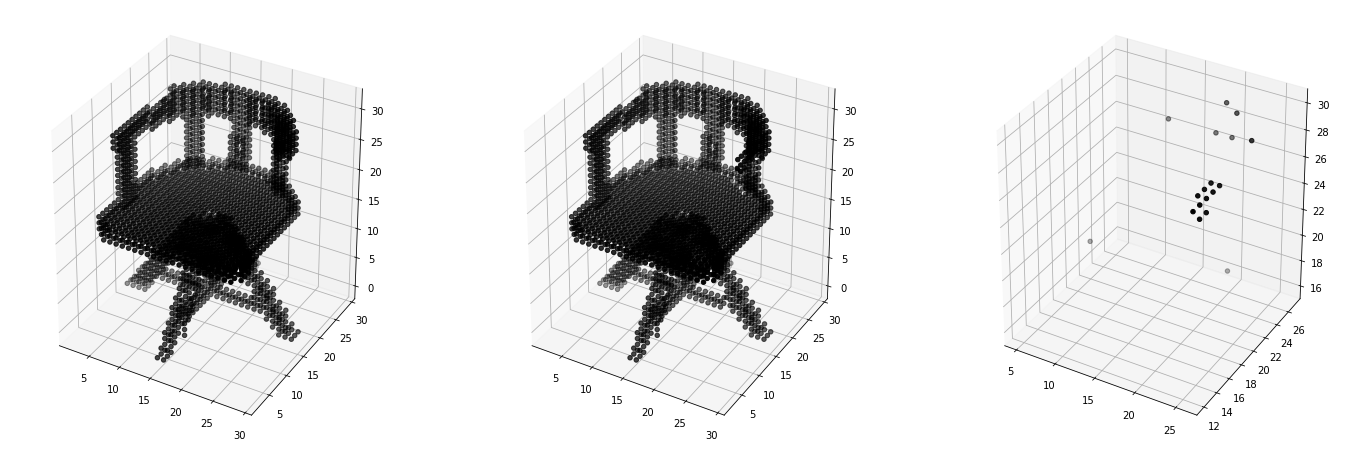

In [50]:
show_tensor_images(array_t, (32,32,32), 1, num_images=1)
show_tensor_images(generated, (32,32,32), 2, num_images=1)
show_tensor_images(patch, (32,32,32), 3, num_images=1)

In [34]:
rs_tensor = lambda obj: np.reshape(obj.detach(), (32,32,32))

In [51]:
plot_vol(rs_tensor(array_t))
plot_vol(rs_tensor(generated))
plot_vol(rs_tensor(patch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:494: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




In [52]:
# plot_vol(np.reshape(array_t.detach(), (32,32,32)))
# plot_vol(np.reshape(generated.detach(), (32,32,32)))
# plot_vol(np.reshape(patch.detach(), (32,32,32)))
plot_reconstruction(rs_tensor(patch), rs_tensor(generated), s = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

